In [359]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from munch import Munch
from scipy.linalg import eigvalsh
from itertools import count

from QO.general import vec2
from QO.hamiltonians import eigs_over_k

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 4.0)

from QO.thermodynamics import GCP_contributions, GCP

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [361]:
def k_space_H(t, k, L, m = 1, U = 0, **kwargs):
    """
         | -2 t_y cos(k_y - l*phi), -t_x, ...     exp(-ik_xL) |
         | -t_x, .                                            |
     H = | 0   ,                                              |
         | .                                                  |
         | exp(ik_xL)  .....                                  |


    """
    phi = 2*np.pi*m / L.x

    #the factor of two along the diagonal comes from  adding the upper and lower triangle together
    upper_triangle = np.diag(U/2 - t.y * np.cos(k.y - np.arange(L.x)*phi), k = 0) \
        - t.x *   np.diag(np.ones(L.x-1), k =  1) \
        + np.exp(-1j * k.x * L.x) * np.diag([1,], k = L.x-1) \
    
    #make hermitian
    H = upper_triangle + upper_triangle.conj().T
    
    return H


def coupling(A, B, coupling = 0):
    """
    Construct a block hamiltonian from two NxN blocks corresponding to subsystems A and B

    H = |A Y|
        |Y B|

    """
    N = A.shape[0]
    Y = np.diag(coupling)
    return np.block([[A, Y],
                     [Y, B]])

offset = 0.5

def H_function(t, k, L, disorder, **kwargs):
    if len(disorder) < L.x: raise ValueError("Need longer disorder vector for hamiltonian!")
    return coupling(k_space_H(t, k, L), k_space_H(t, k, L, U = offset), coupling = disorder[:L.x])

def H_function(t, k, L, disorder, **kwargs):
    if len(disorder) < L.x: raise ValueError("Need longer disorder vector for hamiltonian!")
    return k_space_H(t, k, L) + np.diag(disorder[:L.x])

params = Munch(
#hopping parameters in each direction
t = vec2(1,1),

#the number of unit cells to tile in each direction
N = vec2(100, 3),
) 

def FS(mu): return FS_area(lattice_dispersion, vec2(100,100), mu)

def bands(Mus, index, order):
    "return the position of the ith band at order for each Mu"
    return order * FS(Mus - index * offset)

In [291]:
def real_space_H(t, L, U = 0, **kwargs):
    """
         | U, -t, 0 ... |
         | -t, U -t 0   |
     H = | 0 -t U       |
         | 0            |



    """
    phi = 2*np.pi / L.x

    #the factor of two along the diagonal comes from  adding the upper and lower triangle together
    upper_triangle = np.diag(U/2, k = 0) - t * np.diag(np.ones(L-1), k = 1)
    
    #make hermitian
    H = upper_triangle + upper_triangle.conj().T
    
    return H

offset = 0.5

def H_function(t, k, L, disorder, **kwargs):
    if len(disorder) < 2*L.x: raise ValueError("Need longer disorder vector for hamiltonian!")
    phi = 2*np.pi / L.x
    
    H1 = coupling(k_space_H(t, k, L), k_space_H(t, k, L), coupling = t.y * np.exp(1.j * phi * np.arange(L.x)))
    return H1
    
    H2 = coupling(k_space_H(t, k, L), k_space_H(t, k, L), coupling = t.y * np.exp(1.j * phi * np.arange(L.x)))
    return coupling(H1, H2, coupling = disorder[:2*L.x])
    
params = Munch(
#hopping parameters in each direction
t = vec2(1,1),

#the number of unit cells to tile in each direction
N = vec2(1, 1),
) 

def FS(mu): return FS_area(lattice_dispersion, vec2(100,100), mu)

def bands(Mus, index, order):
    "return the position of the ith band at order for each Mu"
    return order * FS(Mus - index * offset)

In [362]:
coupling_const  = 0.3

def H_function(t, k, L, disorder, **kwargs):
    if len(disorder) < L.x: raise ValueError("Need longer disorder vector for hamiltonian!")
    
    return coupling(k_space_H(t, k, L), k_space_H(t, k, L), coupling = coupling_const * np.ones(L.x)) + np.diag(disorder[:2*L.x])

params = Munch(
#hopping parameters in each direction
t = vec2(1,1),

#the number of unit cells to tile in each direction
N = vec2(3, 3),
) 

def FS(mu): return FS_area(lattice_dispersion, vec2(100,100), mu)

def bands(Mus, index, order):
    "return the position of the ith band at order for each Mu"
    sym = [+1, -1]
    return order * FS(Mus + sym[index] * coupling_const)

In [195]:
def band_sums(Mus): return (bands(Mus, 0, order=1) + bands(Mus, 1, order=1))
def band_diffs(Mus): return np.abs(bands(Mus, 0, order=1) - bands(Mus, 1, order=1))
def plot_bands(ax, Mus, legend = True):
    fig_shape = dict(ylim = ax.get_ylim(), xlim = ax.get_xlim())
    harmonics = 4
    lineargs = dict(linewidth = 2,)
    band_lines = [_, _]
    for m in range(5):
        for i, sign, color in zip([0,1], [0, 1], ["r", "orange"]):
            band_lines[i], = ax.plot(bands(Mus, i, m), Mus, color = color, linestyle = "dotted", **lineargs)

    s, = ax.plot(band_sums(Mus), Mus, color = 'k',
                     linestyle = "dotted", **lineargs)

    d, = ax.plot(band_diffs(Mus), Mus, color = 'k',
                         linestyle = "--", **lineargs)
    
    if legend: ax.legend([band_lines[0], band_lines[1], s, d], ["Band 1", "Band 2", "Sum", "Diff"])
    ax.set(**fig_shape)
    return [band_lines[0], band_lines[1], s, d]

def plot_vlines(ax, mu, legend = True):
    ylim = ax.get_ylim()
    lineargs = dict(linewidth = 2, ymin = ylim[0], ymax = ylim[1])
    band_lines = [_, _]
    for m in range(harmonics):
        for i, sign, color in zip([0,1], [1, -1], ["r", "orange"]):
            band_lines[i] = ax.vlines(x = bands(mu, i, m), color = color, linestyle = "dotted", **lineargs)

    s = ax.vlines(x = band_sums(mu), color = 'k',
                         linestyle = "dotted", **lineargs)

    d = ax.vlines(x = band_diffs(mu), color = 'k',
                             linestyle = "--", **lineargs)
    if legend: ax.legend([band_lines[0], band_lines[1], s, d], ["Band 1", "Band 2", "Sum", "Diff"])
    ax.set(ylim = ylim)
    return [band_lines[0], band_lines[1], s, d]

....................................................................................................
....................................................(400, 12) (400,) (400, 7) (7,)
(400, 12) (400,) (400, 7) (7,)
(400, 12) (400,) (400, 7) (7,)
(400, 12) (400,) (400, 7) (7,)
(400, 12) (400,) (400, 7) (7,)
(400, 12) (400,) (400, 7) (7,)


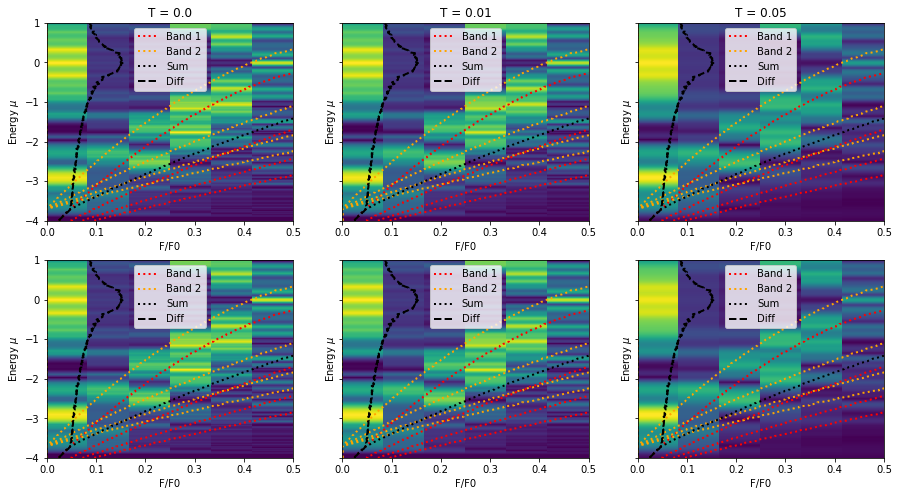

In [363]:
from QO.thermodynamics import GCP_contributions, GCP

min_phi, max_phi = np.pi / 50, np.pi / 10
min_L_x, max_L_x = np.floor(1 / max_phi), np.ceil(1 / min_phi)

L_x = np.arange(min_L_x, max_L_x, dtype = int)

Mus = np.linspace(-4,1,400)
Ts = np.array([0,0.01,0.05])
Repeats = np.arange(1)
disorder_strengths = np.array([0, 0.01, 0.1, 0.5])

params = Munch(
#hopping parameters in each direction
t = vec2(1,1),

#the number of unit cells to tile in each direction
N = vec2(50, 50),
) 

def plotplot(GCPs, lx, m):
        dGCP = np.diff(np.mean(GCPs[:m, n, :, :lx, 0], axis = 0), axis = -1)
        M = - dGCP / dB[:lx-1]
        freqs = np.fft.rfftfreq(M.shape[-1])
        ffts = np.fft.rfft(M, axis = -1)
        f, ax = plt.subplots(figsize = (8,8))
        ax.pcolormesh(freqs, Mus, np.abs(ffts))
        ax.set(ylabel = "Energy $\mu$", xlabel = "F/F0", xlim = (0,0.5))
        band1, band2, s, d = plot_bands(ax, Mus)

mu = -1

B = np.pi / L_x
dB = np.diff(B)

GCPs = np.zeros([len(Repeats), len(disorder_strengths), len(Mus), len(L_x), len(Ts)])

energies = np.linspace(-4,4,5000)
DOS = np.zeros([len(Repeats), len(disorder_strengths), len(L_x), len(energies)-1])

print("." * 100)
c = 0
unit = len(Repeats)*len(disorder_strengths)*len(L_x) // 100
for m in Repeats:
    params.unit_disorder = np.random.uniform(low = -0.5, high = 0.5, size = max(2*L_x))
    
    for n, disorder_strength in enumerate(disorder_strengths):
        params.disorder = params.unit_disorder * disorder_strength
        
        for i, lx in enumerate(L_x):
            c = c + 1 if c < unit else 0
            if c == 0: print('.', end = '')
            eigs = eigs_over_k(H_function, L = vec2(lx, 1), **params)
            DOS[m, n, i], _ = np.histogram(eigs, energies) 

            for j, mu in enumerate(Mus):
                for k, T in enumerate(Ts):
                    GCPs[m, n, j, i, k] = GCP(eigs, mu, T)


all_GCPs = GCPs
all_DOS = DOS
GCPs = GCPs.mean(axis = 0)
DOS = DOS.mean(axis = 0)


f, axes = plt.subplots(nrows = 2, ncols = len(Ts), figsize = (15,8), sharey = 'row')

for n, coupling in enumerate([0, coupling]):
    for k, T in zip(count(), Ts):
        dGCP = np.diff(GCPs[n, :, :, k], axis = -1)

        M = - dGCP / dB

        freqs = np.fft.rfftfreq(M.shape[-1])
        ffts = np.fft.rfft(M, axis = -1)
        print(M.shape, Mus.shape, ffts.shape, freqs.shape)
    
        ax = axes[n, k]
        ax.pcolormesh(freqs, Mus, np.abs(ffts))

        ax.set(ylabel = "Energy $\mu$", xlabel = "F/F0", xlim = (0,0.5))
        if n == 0: ax.set(title = f'T = {T}')
            
        band1, band2, s, d = plot_bands(ax, Mus)

IndexError: tuple index out of range

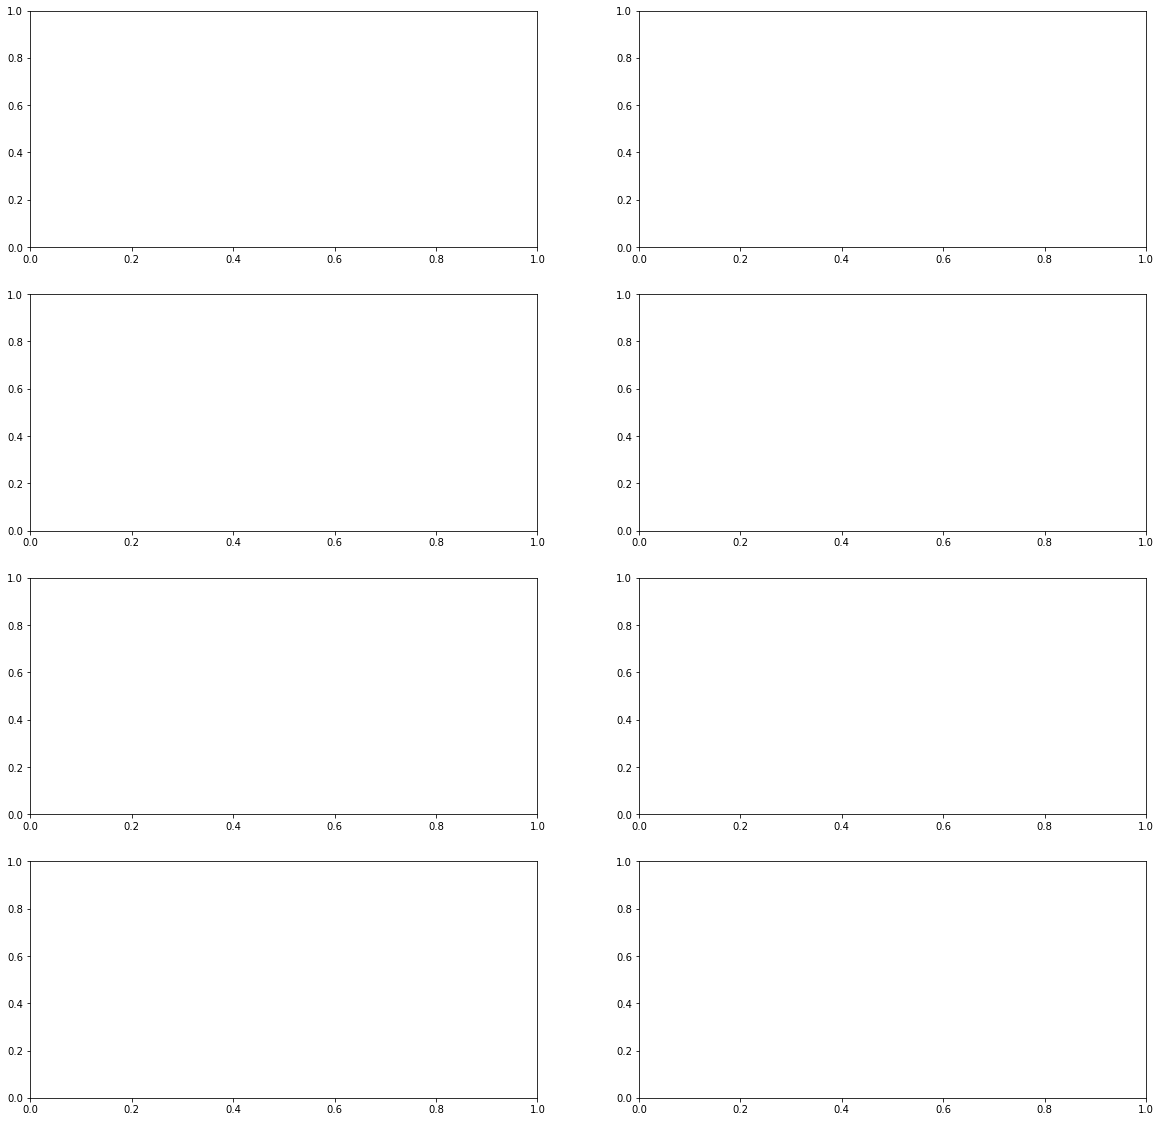

In [504]:
f, axes = plt.subplots(nrows = len(disorder_strengths), ncols = 2, figsize = (20,20))

for n, disorder_strength in enumerate(disorder_strengths):
    axes[n, 0].pcolormesh(1/B, energies[:-1], DOS[n].T, shading = "Gouraud")
    
    axis = -2
    freqs = np.fft.rfftfreq(DOS[n].shape[axis])
    ffts = np.fft.rfft(DOS[n], axis = axis)
    axes[n, 1].pcolormesh(freqs, energies[:-1], np.abs(ffts.T), shading = "Gouraud")
    axes[n, 1].set(ylim = (-4,0), xlim = (0.05, 0.5))
    axes[n, 0].set(ylim = (-4,0), xlim = (0,20))
    
    band1, band2, s, d = plot_bands(axes[n, 1], Mus)

disorder strength = 0.5
T = 0.0
mu = -2.7468671679198


[Text(0, 0.5, 'B**2 * M')]

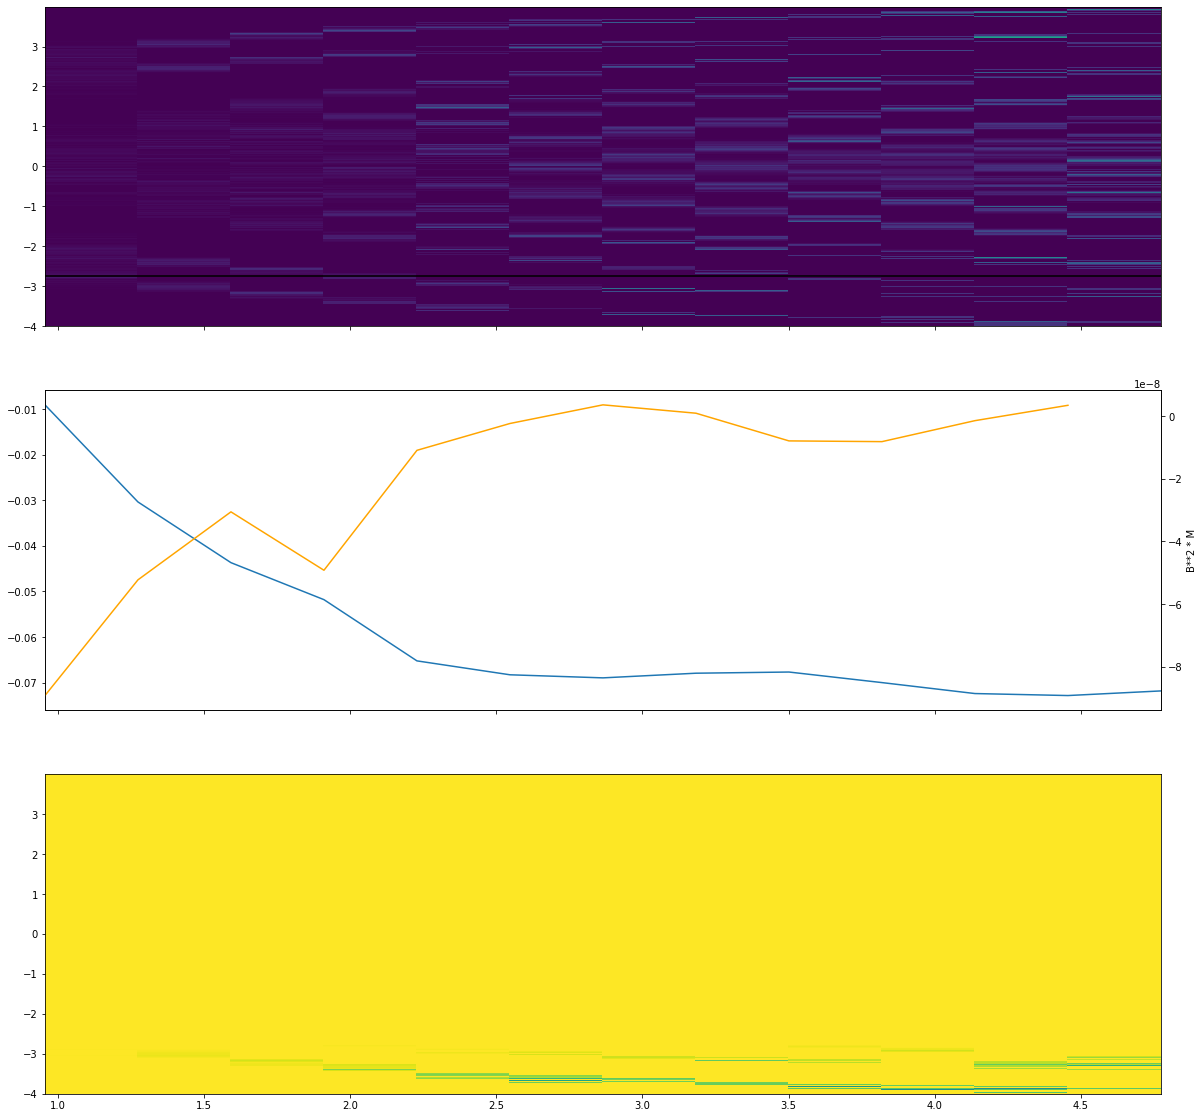

In [368]:
f, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (20,20), squeeze = False, sharex = 'col')

disorder_index = 3
print(f'disorder strength = {disorder_strengths[disorder_index]}')

T_index = 0
print(f'T = {Ts[T_index]}')

Mu_index = 100
mu = Mus[Mu_index]
print(f'mu = {Mus[Mu_index]}')

axes[0, 0].pcolormesh(1/B, energies[:-1], DOS[disorder_index].T)
axes[0,0].hlines(y = mu, xmin = axes[0,0].get_xlim()[0],xmax = axes[0,0].get_xlim()[1])
#axes[0, 0].set(xlim = (1,20), xlabel = "1/B")

GCP_contribs = DOS[disorder_index] * GCP_contributions(energies[None, :-1], mu, Ts[T_index])
GCP = np.sum(GCP_contribs, axis = -1)

axes[2, 0].pcolormesh(1/B, energies[:-1], GCP_contribs.T)

#axes[1, 0].plot(1/B, GCP)
G = GCPs[disorder_index, Mu_index, :, T_index]
axes[1,0].plot(1/B, G)
ax = axes[1,0].twinx()

dGCP = np.diff(G, axis = -1)
dB = np.diff(B)
M = - dGCP / dB / 1e6
ax.plot(1/B[:-1], B[:-1]**2 * M, color = 'orange')
#ax.set(ylim = (-1, 1))
ax.set(ylabel = "B**2 * M")

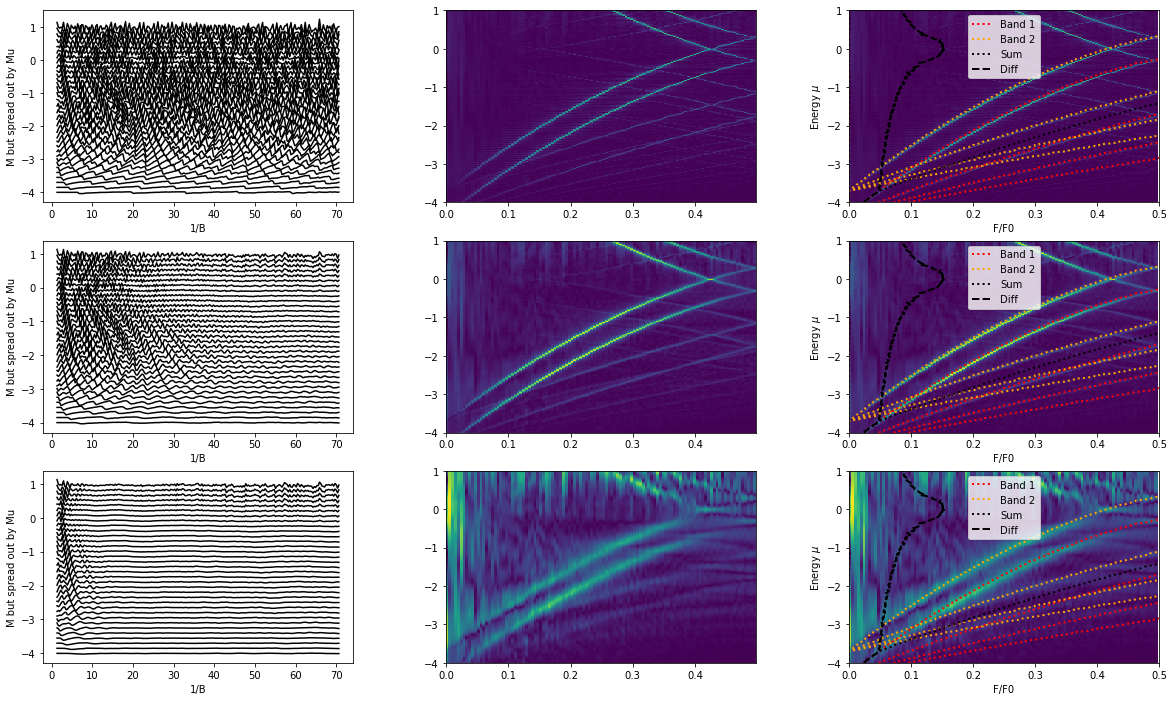

In [349]:
from QO.hamiltonians import FS_area, lattice_dispersion

f, plot_axes = plt.subplots(ncols = 3, nrows = len(Ts), figsize = (20,4*len(Ts)), gridspec_kw = dict(wspace = 0.3))

for k, T, axes in zip(count(), Ts, plot_axes):
    dGCP = np.diff(GCPs[:, :, :, k], axis = -1)
    M = - dGCP / dB
    
    freqs = np.fft.rfftfreq(M.shape[-1])
    ffts = np.fft.rfft(M[1], axis = -1)
    clean_ffts = np.fft.rfft(M[0], axis = -1)

    for j in range(0, len(Mus), 12):
        mu = Mus[j]
        axes[0].plot(B[1:]**-1, M[1, j] + mu, label = f"$\mu$ = {mu}", color = 'k')
    
    axes[1].pcolormesh(freqs, Mus, np.abs(ffts))
    axes[2].pcolormesh(freqs, Mus, np.abs(ffts))

    band1, band2, s, d = plot_bands(axes[2], Mus)

    axes[0].set(ylabel = "M but spread out by Mu", xlabel = "1/B")
    axes[2].set(ylabel = "Energy $\mu$", xlabel = "F/F0", xlim = (0, 0.5))    

In [198]:
mu_index = 100
T_index = 0
Mus[mu_index]

-2.7468671679198

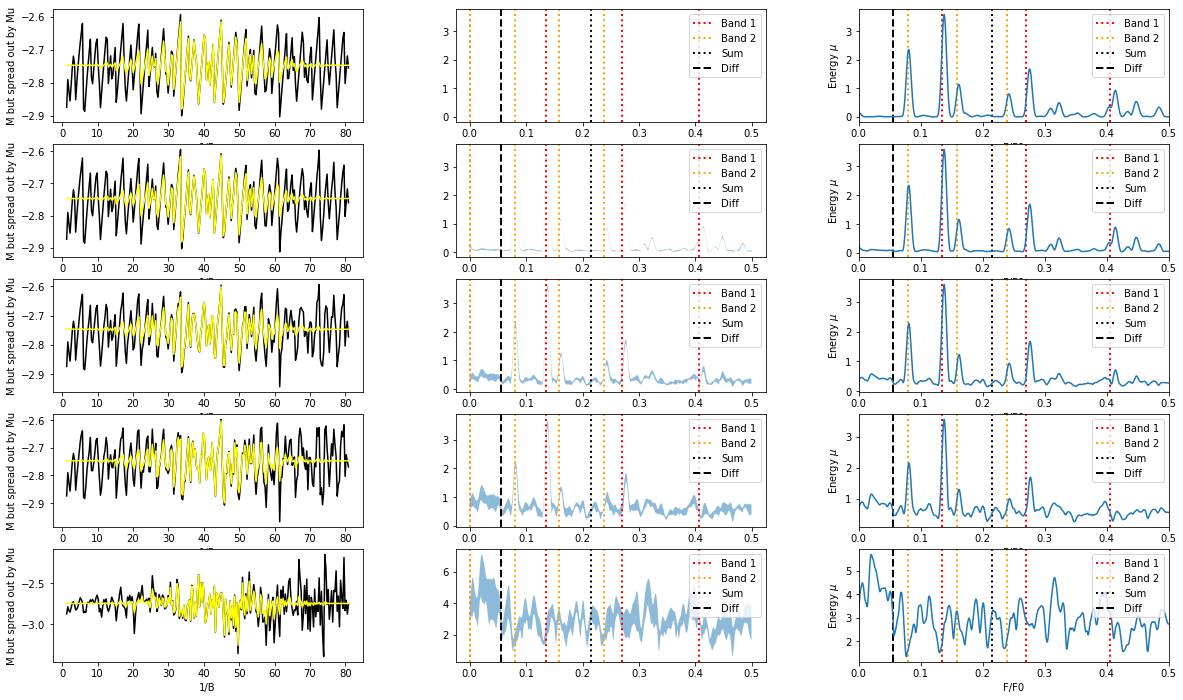

In [202]:
import scipy.signal
f, plot_axes = plt.subplots(ncols = 3, nrows = len(disorder_strengths), figsize = (20,4*len(Ts)), gridspec_kw = dict(wspace = 0.3), squeeze = False)
#GCPs shape = [np.zeros([len(Repeats), ]len(disorder_strengths), len(Mus), len(L_x), len(Ts)])

for disorder_index, disorder_strength, axes in zip(count(), disorder_strengths, plot_axes):
    dGCP = np.diff(GCPs[disorder_index, mu_index, :, T_index], axis = -1)
    M = - dGCP / dB

    window = scipy.signal.windows.get_window("blackman", M.shape[-1])
    windowed_M =  M * window

    pad_to = 1000
    padding = (pad_to - M.shape[-1]) // 2
    pad_width = [(0,0),] * (len(windowed_M.shape)-1) + [(padding, padding),]
    padded_M = np.pad(windowed_M, pad_width, constant_values = 0)

    freqs = np.fft.rfftfreq(padded_M.shape[-1])
    ffts = np.fft.rfft(padded_M, axis = -1)[0]
    
    ddGCP = np.diff(all_GCPs[:, disorder_index, mu_index, :, T_index], axis = -1)
    dM = - ddGCP / dB
    pad_width = [(0,0),] * (len(dM.shape)-1) + [(padding, padding),]
    padded_dM = np.pad(dM * window, pad_width, constant_values = 0)
    
    from scipy.stats import sem
    multiples_ffts = np.fft.rfft(padded_dM, axis = -1)
    dffts = sem(np.abs(multiples_ffts), axis = 0)
    mean_ffts = np.mean(np.abs(multiples_ffts), axis = 0)
    
    mu = Mus[mu_index]
    axes[0].plot(B[1:]**-1, M + mu, label = f"$\mu$ = {mu}", color = 'k')
    axes[0].plot(B[1:]**-1, windowed_M + mu, label = f"$\mu$ = {mu}", color = 'yellow')

    #axes[1].plot(freqs, np.abs(ffts))
    axes[2].plot(freqs, np.abs(mean_ffts))
    axes[1].fill_between(freqs, mean_ffts - dffts, mean_ffts + dffts, alpha = 0.5)

    plot_vlines(axes[1], mu)
    plot_vlines(axes[2], mu)

    axes[0].set(ylabel = "M but spread out by Mu", xlabel = "1/B")
    axes[2].set(ylabel = "Energy $\mu$", xlabel = "F/F0", xlim = (0, 0.5))


In [150]:
from itertools import count
params = Munch(
#hopping parameters in each direction
t = vec2(1,1),

#the number of unit cells to tile in each direction
N = vec2(50, 3),
) 


min_phi, max_phi = np.pi / 700, np.pi / 10
min_L_x, max_L_x = np.floor(1 / max_phi), np.ceil(1 / min_phi)

L_x = np.arange(min_L_x, max_L_x, dtype = int)

Mus = np.array([-2.5,])
T = 0
disorder_strengths = np.array([0.01, 0.02, 0.09, 0.5])
Repeats = np.arange(2)

B = np.pi / L_x
dB = np.diff(B)

GCPs_single = np.zeros([len(Repeats), len(Mus), len(L_x), len(disorder_strengths)])

for m in Repeats:
    params.unit_disorder = np.random.uniform(low = -0.5, high = 0.5, size = max(2*L_x))
    
    for k, disorder_strength in enumerate(disorder_strengths):
        print(f'\ndisorder strength = {disorder_strength}')
        params.disorder = disorder_strength * params.unit_disorder

        for i, lx in enumerate(L_x):
            print('.', end = '')
            eigs = eigs_over_k(H_function, L = vec2(lx, 1), **params)

            for j, mu in enumerate(Mus):
                    GCPs_single[m, j, i, k] = GCP(eigs, mu, T)
    
all_GCPs = GCPs_single
GCPs_single = GCPs_single.mean(axis = 0)


disorder strength = 0.01
............................................................................................................................................................................................................................
disorder strength = 0.02
............................................................................................................................................................................................................................
disorder strength = 0.09
............................................................................................................................................................................................................................
disorder strength = 0.5
............................................................................................................................................................................................................................
disorder strengt

(2, 1, 219)
(2, 1, 219)
(2, 1, 219)
(2, 1, 219)


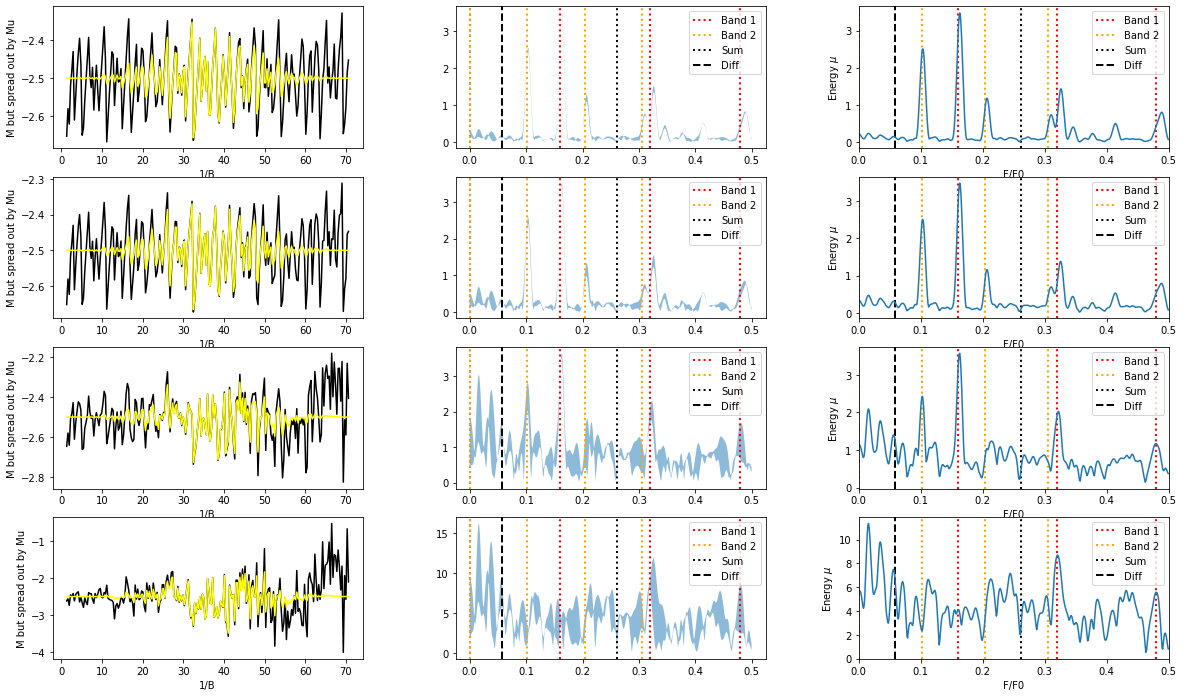

In [154]:
import scipy.signal
f, plot_axes = plt.subplots(ncols = 3, nrows = len(disorder_strengths), figsize = (20,4*len(Ts)), gridspec_kw = dict(wspace = 0.3), squeeze = False)


for k, disorder_strength, axes in zip(count(), disorder_strengths, plot_axes):
    dGCP = np.diff(GCPs_single[..., k], axis = -1)
    M = - dGCP / dB

    window = scipy.signal.windows.get_window("blackman", M.shape[-1])
    windowed_M =  M * window

    pad_to = 1000
    padding = (pad_to - M.shape[-1]) // 2
    padded_M = np.pad(windowed_M, pad_width = ((0,0), (padding, padding)), constant_values = 0)

    freqs = np.fft.rfftfreq(padded_M.shape[-1])
    ffts = np.fft.rfft(padded_M, axis = -1)[0]
    
    ddGCP = np.diff(all_GCPs[..., k], axis = -1)
    print(ddGCP.shape)
    dM = - ddGCP / dB
    padded_dM = np.pad(dM * window, pad_width = ((0,0), (0,0), (padding, padding)), constant_values = 0)
    
    from scipy.stats import sem
    multiples_ffts = np.fft.rfft(padded_dM, axis = -1)[:, 0]
    dffts = sem(np.abs(multiples_ffts), axis = 0)
    mean_ffts = np.mean(np.abs(multiples_ffts), axis = 0)
    
    mu = Mus[0]
    axes[0].plot(B[1:]**-1, M[0] + mu, label = f"$\mu$ = {mu}", color = 'k')
    axes[0].plot(B[1:]**-1, windowed_M[0] + mu, label = f"$\mu$ = {mu}", color = 'yellow')

    #axes[1].plot(freqs, np.abs(ffts))
    axes[2].plot(freqs, np.abs(mean_ffts))
    axes[1].fill_between(freqs, mean_ffts - dffts, mean_ffts + dffts, alpha = 0.5)

    plot_vlines(axes[1], mu)
    plot_vlines(axes[2], mu)

    axes[0].set(ylabel = "M but spread out by Mu", xlabel = "1/B")
    axes[2].set(ylabel = "Energy $\mu$", xlabel = "F/F0", xlim = (0, 0.5))


(1, 1, 156)
(1, 1, 156)
(1, 1, 156)
(1, 1, 156)


/Users/tom/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/tom/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/tom/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Legend does not support array([-4.        , -3.99199199, -3.98398398, -3.97597598, -3.96796797,
       -3.95995996, -3.95195195, -3.94394394, -3.93593594, -3.92792793,
       -3.91991992, -3.91191191, -3.9039039 , -3.8958959 , -3.88788789,
       -3.87987988, -3.87187187, -3.86386386, -3.85585586, -3.84784785,
       -3.83983984, -3.83183183, -3.82382382, -3.81581582, -3.80780781,
       -3.7997998 , -3.79179179, -3.78378378, -3.77577578, -3.76776777,
       -3.75975976, -3.75175175, -3.74374374, -3.73573574, -3.72772773,
       -3.71971972, -3.71171171, -3.7037037 

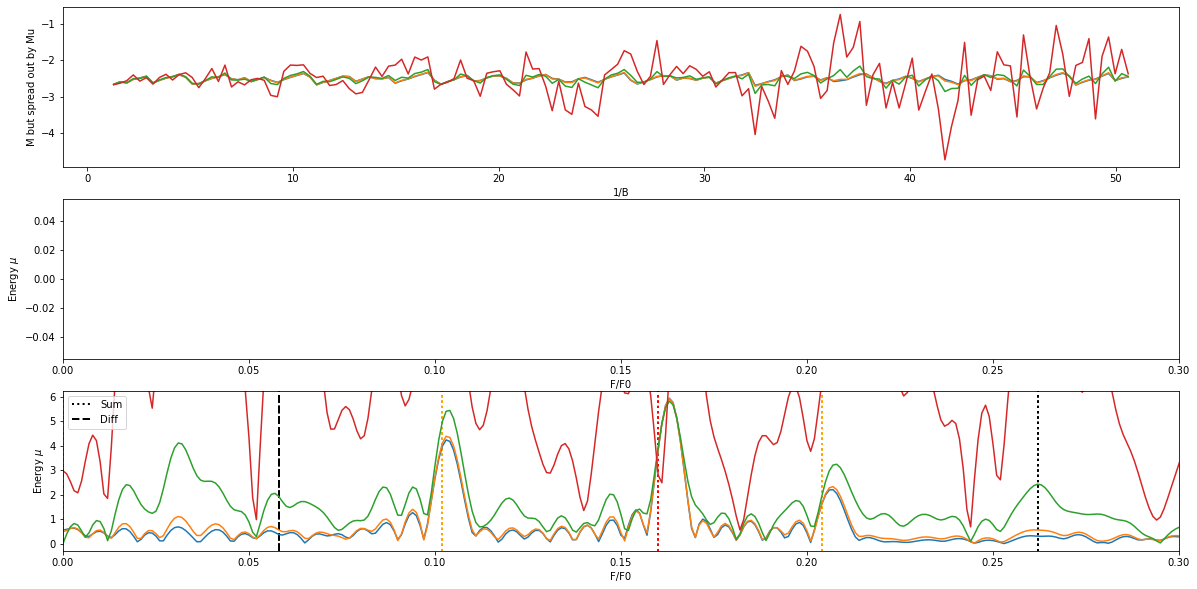

In [148]:
import scipy.signal


f, axes = plt.subplots(ncols = 1, nrows = 3, figsize = (20,10), gridspec_kw = dict(wspace = 0.3))


for k, disorder_strength in zip(count(), disorder_strengths):
    dGCP = np.diff(GCPs_single[..., k], axis = -1)
    M = - dGCP / dB

    window = scipy.signal.windows.get_window("boxcar", M.shape[-1])
    windowed_M =  M * window

    pad_to = 1000
    padding = (pad_to - M.shape[-1]) // 2
    padded_M = np.pad(windowed_M, pad_width = ((0,0), (padding, padding)), constant_values = 0)

    freqs = np.fft.rfftfreq(padded_M.shape[-1])
    ffts = np.fft.rfft(padded_M, axis = -1)[0]
    
    ddGCP = np.diff(all_GCPs[..., k], axis = -1)
    print(ddGCP.shape)
    dM = - ddGCP / dB
    padded_dM = np.pad(dM * window, pad_width = ((0,0), (0,0), (padding, padding)), constant_values = 0)
    
    from scipy.stats import sem
    multiples_ffts = np.fft.rfft(padded_dM, axis = -1)[:, 0]
    dffts = sem(np.abs(multiples_ffts), axis = 0)
    mean_ffts = np.mean(np.abs(multiples_ffts), axis = 0)
    
    mu = Mus[0]
    axes[0].plot(B[1:]**-1, M[0] + mu, label = f"$\mu$ = {mu}")

    #axes[1].plot(freqs, np.abs(ffts))
    axes[2].plot(freqs, np.abs(mean_ffts))
    axes[1].fill_between(freqs, mean_ffts - dffts, mean_ffts + dffts, alpha = 0.7)

    plot_vlines(axes[2], mu)

    axes[0].set(ylabel = "M but spread out by Mu", xlabel = "1/B")
    axes[1].set(ylabel = "Energy $\mu$", xlabel = "F/F0", xlim = (0, 0.3))
    axes[2].set(ylabel = "Energy $\mu$", xlabel = "F/F0", xlim = (0, 0.3))


    axes[2].legend([pred[0], pred[1], s, d], ["Band 1", "Band 2", "Sum", "Diff"])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  

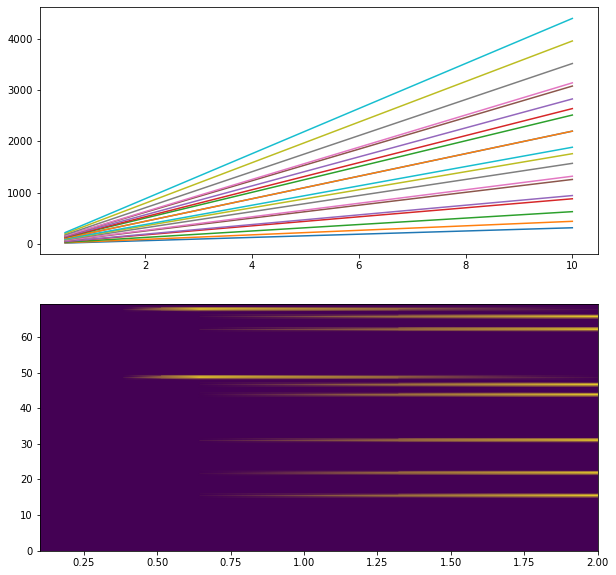

In [530]:
landau_levels = 10
w1, w2 = 5, 7
gamma = 0
bins = np.linspace(0, landau_levels * w2,  landau_levels*10)
Bs = np.linspace(0.5,10,10)
hist = np.empty(shape = (len(Bs), len(bins)-1))
eigarray = np.empty(shape = (len(Bs), 2*landau_levels))


for i,B in enumerate(Bs):
    H1 = np.diag(2*np.pi*w1 *B * np.arange(1,landau_levels+1))
    H2 = np.diag(2*np.pi*w2 * B *np.arange(1,landau_levels+1))

    g = gamma * np.random.uniform(-1,1, size = (landau_levels, landau_levels))


    coupled = np.block([[H1,    g],
                        [g, H2]])

    eigs, vecs = np.linalg.eig(coupled)
    eigarray[i] = sorted(eigs)
    hist[i], _ = np.histogram(eigs, bins, density = False)
    
print(hist)
f, axes = plt.subplots(nrows = 2,figsize = (10,10))
axes[0].plot(Bs, eigarray)
axes[1].pcolormesh(1/Bs, bins[:-1], hist.T, shading = 'Gouraud', antialiased=False, vmax = 0.1)

/Users/tom/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[(0.0, 10.0)]

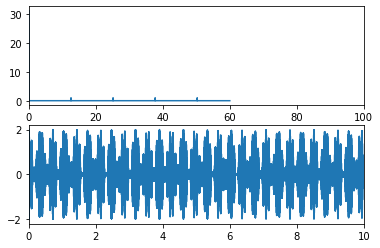

In [456]:
f, axes = plt.subplots(nrows= 2)
axes[0].plot(bins[:-1], hist)
axes[0].set(xlim = (0, 100))


window = scipy.signal.windows.get_window("blackman", hist.shape[-1])

pad_to = 100000
padding = (pad_to - hist.shape[-1]) // 2
padded = np.pad(hist * window, pad_width = padding, constant_values = 0)

freqs = np.fft.rfftfreq(padded.shape[0], d = np.abs(bins[1]-bins[0]))
ffts = np.fft.rfft(padded)

axes[1].plot(freqs, ffts)
axes[1].set(xlim = (0, 10))

In [401]:
help(np.fft.rfftfreq)

Help on function rfftfreq in module numpy.fft:

rfftfreq(n, d=1.0)
    Return the Discrete Fourier Transform sample frequencies
    (for usage with rfft, irfft).
    
    The returned float array `f` contains the frequency bin centers in cycles
    per unit of the sample spacing (with zero at the start).  For instance, if
    the sample spacing is in seconds, then the frequency unit is cycles/second.
    
    Given a window length `n` and a sample spacing `d`::
    
      f = [0, 1, ...,     n/2-1,     n/2] / (d*n)   if n is even
      f = [0, 1, ..., (n-1)/2-1, (n-1)/2] / (d*n)   if n is odd
    
    Unlike `fftfreq` (but like `scipy.fftpack.rfftfreq`)
    the Nyquist frequency component is considered to be positive.
    
    Parameters
    ----------
    n : int
        Window length.
    d : scalar, optional
        Sample spacing (inverse of the sampling rate). Defaults to 1.
    
    Returns
    -------
    f : ndarray
        Array of length ``n//2 + 1`` containing the sample fre

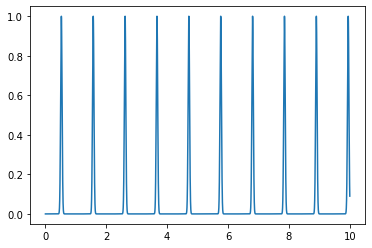

In [394]:
x = np.linspace(0, 10, 10000)
w1 = 1
w2 = 3

y1 = np.sin(w1*x)**100
y2 = np.sin(w2*x)**100

#plt.plot(x, y1)
plt.plot(x, y2 * y2)